<a href="https://colab.research.google.com/github/napatt2/QuakeNN/blob/main/Wave%20Equation/Forward_vector_wave2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.io import loadmat
import os

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# Formulation of the Problem
Our goal is to predict the solution of vecotor wave equation. The formulation can be written as follows:

\begin{align}
\rho u_{1,tt} &= \sigma_{11,1} + \sigma_{12,2}\\
\rho u_{2,tt} &= \sigma_{21,1} + \sigma_{22,2}\\
\epsilon_{11} &=  u_{1,1}\\
\epsilon_{22} &= u_{2,2}\\
\epsilon_{12} &= \dfrac{1}{2}\left[u_{1,2} + u_{2,1} \right]\\
\sigma_{11} &= \dfrac{E}{1-\nu^2}\epsilon_{11}+\dfrac{\nu E}{1-\nu^2}\epsilon_{22}\\
\sigma_{22} &= \dfrac{\nu E}{1-\nu^2}\epsilon_{11}+\dfrac{E}{1-\nu^2}\epsilon_{22}\\
\sigma_{12} &= \dfrac{E}{(1+\nu)}\epsilon_{12}\
\end{align}

where initial conditions are $\dot{u}(0) = \exp(-20(0.5-x)^2 - 20(0.5-y)^2)$, $\dot{w}(0) = 0$, $\tau_{xx}(0) = 0$, $\tau_{xy}(0) = 0$, $\tau_{yy}(0) = 0$. The parameters $\lambda=50, \mu=30,$ and $\rho=2.7$ are chosen to represent the material properties of rocks.

In [2]:
lamb = 50
mu = 30
rho = 2.7

In [3]:
def pde(x, y):
    '''Define a system of PDE to be used as loss function
      Input  x: input neurons representing (x, y, t)
             y: output from neuron network (u, w, tauxx, tauxy, tauyy)

      Return a list of equations to be used in loss function'''

    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dw_x = dde.grad.jacobian(y, x, i=1, j=0)
    dw_y = dde.grad.jacobian(y, x, i=1, j=1)
    dw_t = dde.grad.jacobian(y, x, i=1, j=2)

    dtauxx_x = dde.grad.jacobian(y, x, i=2, j=0)
    dtauxx_y = dde.grad.jacobian(y, x, i=2, j=1)
    dtauxx_t = dde.grad.jacobian(y, x, i=2, j=2)
    dtauxy_x = dde.grad.jacobian(y, x, i=3, j=0)
    dtauxy_y = dde.grad.jacobian(y, x, i=3, j=1)
    dtauxy_t = dde.grad.jacobian(y, x, i=3, j=2)
    dtauyy_x = dde.grad.jacobian(y, x, i=4, j=0)
    dtauyy_y = dde.grad.jacobian(y, x, i=4, j=1)
    dtauyy_t = dde.grad.jacobian(y, x, i=4, j=2)

    return [- du_t + lamb/rho * (dtauxx_x + dtauxy_y),
            - dw_t + lamb/rho * (dtauxy_x + dtauyy_y),
            - dtauxx_t + (lamb + 2*mu)/lamb * du_x + dw_y,
            - dtauxy_t + mu/lamb * (du_y + dw_x),
            - dtauyy_t + (lamb + 2*mu)/lamb * dw_y + du_x]

In [4]:
def func(x):
    x, y, t = np.split(x, 3, axis=1)
    return np.exp(-20*(1/2-x)**2-20*(1/2-y)**2)  #Define initial condition of u

def func_ic(x):
    return 0 #Define initial condition of w, tauxx, tauxy, tauyy

def boundary_rx(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1) # Define position of right boundary

def boundary_lx(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0) # Define position of left boundary

def boundary_ry(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1) # Define position of top boundary

def boundary_ly(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0) # Define position of bottom boundary

In [5]:
def get_initial_loss(model):
    # get loss of the first iteration to weight the loss function
    model.compile("adam", lr=0.001)
    losshistory, train_state = model.train(0)
    return losshistory.loss_train[0]

In [ ]:
# Spatial domain: X × Y = [0, 1] × [0, 1]
Lx_min, Lx_max = 0.0, 1.0
Ly_min, Ly_max = 0.0, 1.0
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

# Time domain: T = [0, 0.001]
time_domain = dde.geometry.TimeDomain(0.0, 0.001)

# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# Define Dirichlet boundary conditions
bc1 = dde.PeriodicBC(geomtime, 0, boundary_rx, derivative_order=0, component=0)
bc2 = dde.PeriodicBC(geomtime, 0, boundary_lx, derivative_order=0, component=0)
bc3 = dde.PeriodicBC(geomtime, 1, boundary_ry, derivative_order=0, component=0)
bc4 = dde.PeriodicBC(geomtime, 1, boundary_ly, derivative_order=0, component=0)
bc5 = dde.PeriodicBC(geomtime, 0, boundary_rx, derivative_order=0, component=1)
bc6 = dde.PeriodicBC(geomtime, 0, boundary_lx, derivative_order=0, component=1)
bc7 = dde.PeriodicBC(geomtime, 1, boundary_ry, derivative_order=0, component=1)
bc8 = dde.PeriodicBC(geomtime, 1, boundary_ly, derivative_order=0, component=1)
bc9 = dde.PeriodicBC(geomtime, 0, boundary_rx, derivative_order=0, component=2)
bc10 = dde.PeriodicBC(geomtime, 0, boundary_lx, derivative_order=0, component=2)
bc11 = dde.PeriodicBC(geomtime, 1, boundary_ry, derivative_order=0, component=2)
bc12 = dde.PeriodicBC(geomtime, 1, boundary_ly, derivative_order=0, component=2)
bc13 = dde.PeriodicBC(geomtime, 0, boundary_rx, derivative_order=0, component=3)
bc14 = dde.PeriodicBC(geomtime, 0, boundary_lx, derivative_order=0, component=3)
bc15 = dde.PeriodicBC(geomtime, 1, boundary_ry, derivative_order=0, component=3)
bc16 = dde.PeriodicBC(geomtime, 1, boundary_ly, derivative_order=0, component=3)
bc17 = dde.PeriodicBC(geomtime, 0, boundary_rx, derivative_order=0, component=4)
bc18 = dde.PeriodicBC(geomtime, 0, boundary_lx, derivative_order=0, component=4)
bc19 = dde.PeriodicBC(geomtime, 1, boundary_ry, derivative_order=0, component=4)
bc20 = dde.PeriodicBC(geomtime, 1, boundary_ly, derivative_order=0, component=4)

# Define initial conditions
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial, component=0)
ic_2 = dde.icbc.IC(geomtime, func_ic, lambda _, on_initial: on_initial, component=1)
ic_3 = dde.icbc.IC(geomtime, func_ic, lambda _, on_initial: on_initial, component=2)
ic_4 = dde.icbc.IC(geomtime, func_ic, lambda _, on_initial: on_initial, component=3)
ic_5 = dde.icbc.IC(geomtime, func_ic, lambda _, on_initial: on_initial, component=4)

# Compile and Train Model
We train the model using spatio-temporal multi-scale fourier feature networks (`dde.nn.STMsFFN`)
 ([Wang et al., 2021](https://www.sciencedirect.com/science/article/pii/S0045782521002759?via%3Dihub)). The model uses 360 collocation points in the domain, 360 points at the boundary, 400 points for initial conditions, and 10000 test pooints. We use `pde_residual_resampler` which resample the residual points for every iteration.

Compiling model...
Building Spatio-temporal Multi-scale Fourier Feature Network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 8.992895 s

Training model...

Step      Train loss                                                                                                                                                                                                                                                                                                      Test loss                                                                                                                                                                                                                                                                                                       Test metric
0         [3.38e+04, 3.39e+04, 4.53e+02, 8.46e+01, 4.95e+02, 1.96e-01, 2.00e-01, 1.21e-01, 1.27e-01, 2.71e-01, 2.62e-01, 1.09e-01, 1.15e-01, 1.11e-01, 1.20e-01, 6.94e-02, 7.78e-02, 9.99e-02, 9.78e-02, 2.32e-01, 2.35e-01, 1.94e-01, 1.84e-01, 2.77e-01, 2.61e-01, 2.06e-01, 7.82e-02, 4.46e-02, 6.89e-02, 6.62e-02]    [3.63e+04,

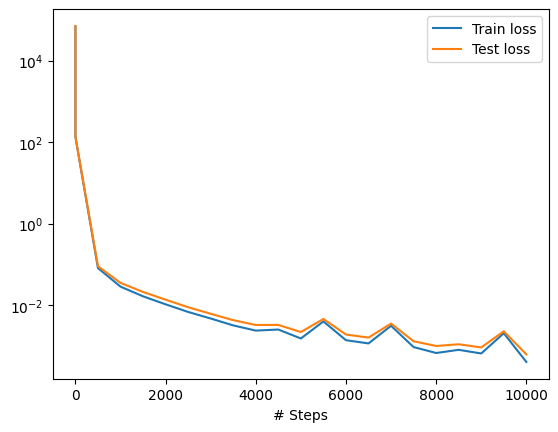

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc1, bc2, bc3, bc4, bc5, bc6, bc7, bc8, bc9, bc10, bc11, bc12, bc13, bc14, bc15, bc16, bc17, bc18, bc19, bc20, ic_1, ic_2, ic_3, ic_4, ic_5],
    num_domain=360,
    num_boundary=360,
    num_initial=400,
    num_test=10000,
)

layer_size = [3] + [100] * 3 + [5]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.STMsFFN(
    layer_size, activation, initializer, sigmas_x=[1, 10], sigmas_t=[1, 10]
)
net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))

model = dde.Model(data, net)
initial_losses = get_initial_loss(model)
loss_weights = 5 / initial_losses

model.compile(
    "adam",
    lr=0.001,
    loss_weights=loss_weights,
    decay=("inverse time", 2000, 0.9),
)

path = "./../output/Model/model"
os.makedirs(path, exist_ok=True)
checkpoint_path = os.path.join(path, "model.ckpt")
checker = dde.callbacks.ModelCheckpoint(
      checkpoint_path, save_better_only=True, period=50
  )

pde_residual_resampler = dde.callbacks.PDEPointResampler(period=1)
losshistory, train_state = model.train(
    iterations=10000, callbacks=[pde_residual_resampler, checker], display_every=500
)

# Import Dataset
We solved vector wave equation numerically using finite difference method. We compare the predictions to the data.

In [ ]:
data = loadmat('./../Dataset/vector_wave.mat')
u = data['u_log'].transpose(1, 0, 2)
w = data['w_log'].transpose(1, 0, 2)
tauxx = data['tauxx_log'].transpose(1, 0, 2)
tauxy = data['tauxy_log'].transpose(1, 0, 2)
tauyy = data['tauyy_log'].transpose(1, 0, 2)
tspan = data['time_log']

# Prediction
We predict the solutions of $\dot{u}, \dot{w}, \tau_{xx}, \tau_{xy},$ and $\tau_{yy}$ using 101x101 spatial points and 11 time steps from time 0 to 0.001.

In [ ]:
# Define the prediction domain
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
t = np.linspace(0, 0.001, 11)
xv, yv, tv = np.meshgrid(x, y, t)

x_test = xv.flatten()[:,None]
y_test = yv.flatten()[:,None]
t_test = tv.flatten()[:,None]
ob_xyt = np.hstack((x_test, y_test, t_test))

# Predict the solutions
pred = model.predict(ob_xyt)
u_pred = pred[:,0].reshape((101,101,11))
w_pred = pred[:,1].reshape((101,101,11))
tauxx_pred = pred[:,2].reshape((101,101,11))
tauxy_pred = pred[:,3].reshape((101,101,11))
tauyy_pred = pred[:,4].reshape((101,101,11))

# Plotting

Text(0.5, 0.98, 'Prediction of u at t = 0.001')

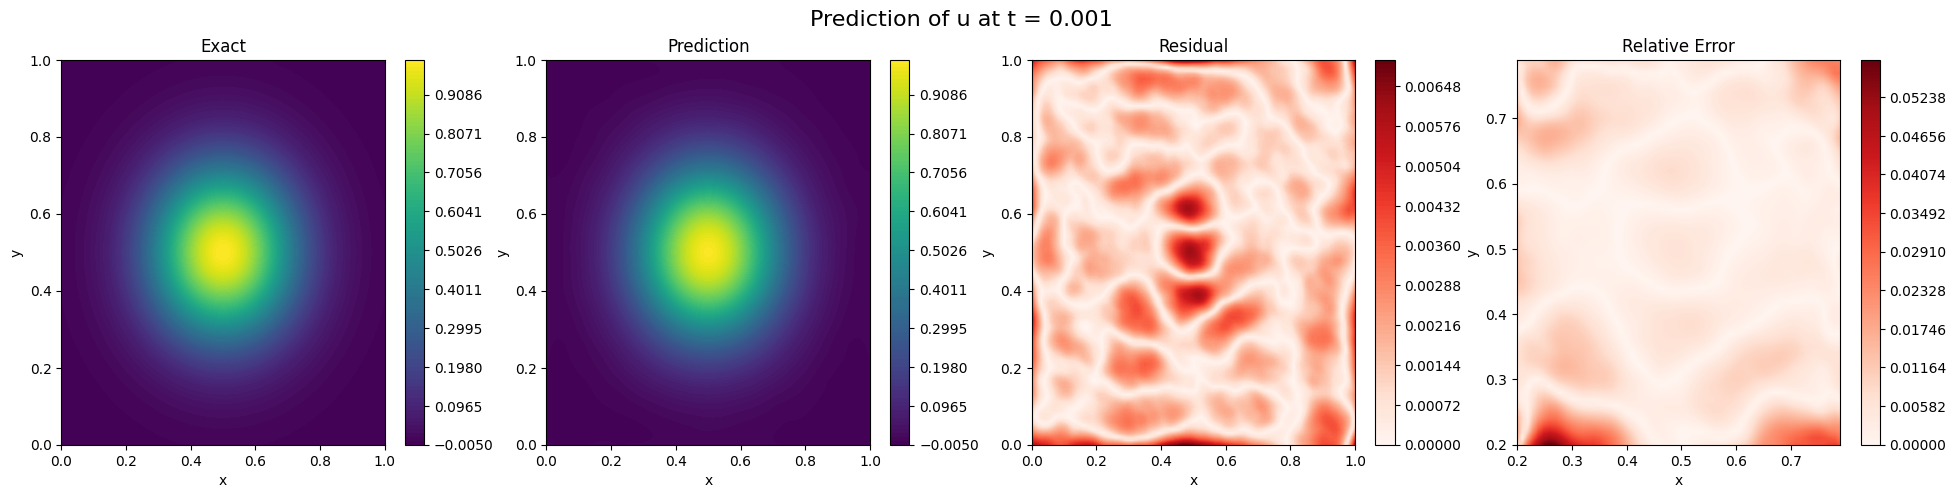

In [ ]:
index = 10
levels = np.linspace(-0.005,1,100)
levels_res = 100
fig,ax=plt.subplots(1,4, figsize = (24,5))
cp0 = ax[0].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), u[:,:,index].reshape((101,101)), levels)
cp1 = ax[1].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), u_pred[:,:,index].reshape((101,101)), levels)
cp2 = ax[2].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), np.abs((u[:,:,index].reshape((101,101)) - u_pred[:,:,index].reshape((101,101)))), levels_res, cmap=cm.Reds)
cp3 = ax[3].contourf(xv[20:80,20:80,0].reshape((60,60)), yv[20:80,20:80,0].reshape((60,60)), np.abs((u[20:80,20:80,index] - u_pred[20:80,20:80,index].reshape((60,60)))/u[20:80,20:80, index]), 1000, cmap=cm.Reds)

fig.colorbar(cp3, ax=ax[3])
fig.colorbar(cp2, ax=ax[2])
fig.colorbar(cp1, ax=ax[1])
fig.colorbar(cp0, ax=ax[0])

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[3].set_xlabel('x')
ax[3].set_ylabel('y')

ax[0].set_title('Exact')
ax[1].set_title('Prediction')
ax[2].set_title('Residual')
ax[3].set_title('Relative Error')
fig.suptitle(r'Prediction of u at t = 0.001', fontsize=16)

<ipython-input-12-f368cf1fd5ee>:8: RuntimeWarning: divide by zero encountered in divide
  cp3 = ax[3].contourf(xv[20:80,20:80,0].reshape((60,60)), yv[20:80,20:80,0].reshape((60,60)), np.abs((w[20:80,20:80,index] - w_pred[20:80,20:80,index].reshape((60,60)))/w[20:80,20:80, index]), 1000, cmap=cm.Reds)


Text(0.5, 0.98, 'Prediction of w at t = 0.001')

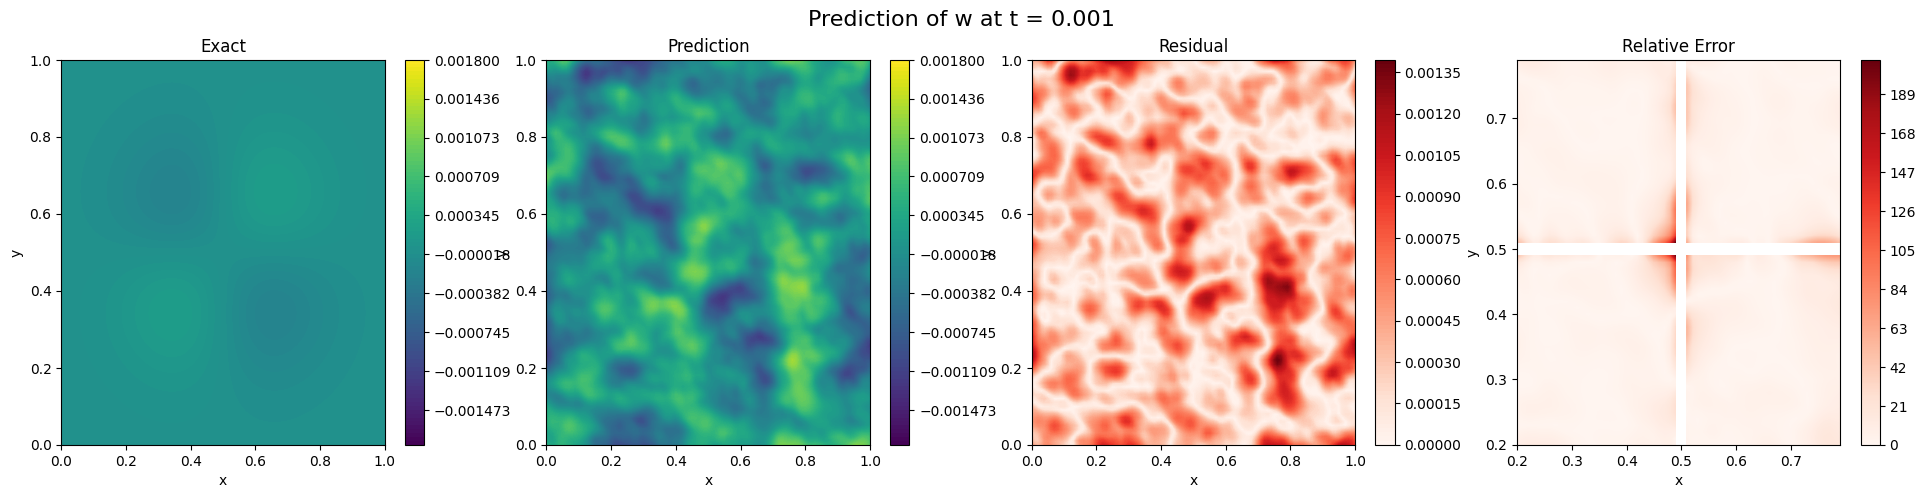

In [ ]:
index = 10
levels = np.linspace(-0.0018,0.0018,100)
levels_res = 100
fig,ax=plt.subplots(1,4, figsize = (24,5))
cp0 = ax[0].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), w[:,:,index].reshape((101,101)), levels)
cp1 = ax[1].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), w_pred[:,:,index].reshape((101,101)), levels)
cp2 = ax[2].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), np.abs((w[:,:,index].reshape((101,101)) - w_pred[:,:,index].reshape((101,101)))), levels_res, cmap=cm.Reds)
cp3 = ax[3].contourf(xv[20:80,20:80,0].reshape((60,60)), yv[20:80,20:80,0].reshape((60,60)), np.abs((w[20:80,20:80,index] - w_pred[20:80,20:80,index].reshape((60,60)))/w[20:80,20:80, index]), 1000, cmap=cm.Reds)

fig.colorbar(cp3, ax=ax[3])
fig.colorbar(cp2, ax=ax[2])
fig.colorbar(cp1, ax=ax[1])
fig.colorbar(cp0, ax=ax[0])

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[3].set_xlabel('x')
ax[3].set_ylabel('y')

ax[0].set_title('Exact')
ax[1].set_title('Prediction')
ax[2].set_title('Residual')
ax[3].set_title('Relative Error')
fig.suptitle(r'Prediction of w at t = 0.001', fontsize=16)

<ipython-input-13-67c4c5a725bc>:8: RuntimeWarning: divide by zero encountered in divide
  cp3 = ax[3].contourf(xv[20:80,20:80,0].reshape((60,60)), yv[20:80,20:80,0].reshape((60,60)), np.abs((tauxx[20:80,20:80,index] - tauxx_pred[20:80,20:80,index].reshape((60,60)))/tauxx[20:80,20:80, index]), 1000, cmap=cm.Reds)


Text(0.5, 0.98, 'Prediction of $\\tau_{xx}$ at t = 0.001')

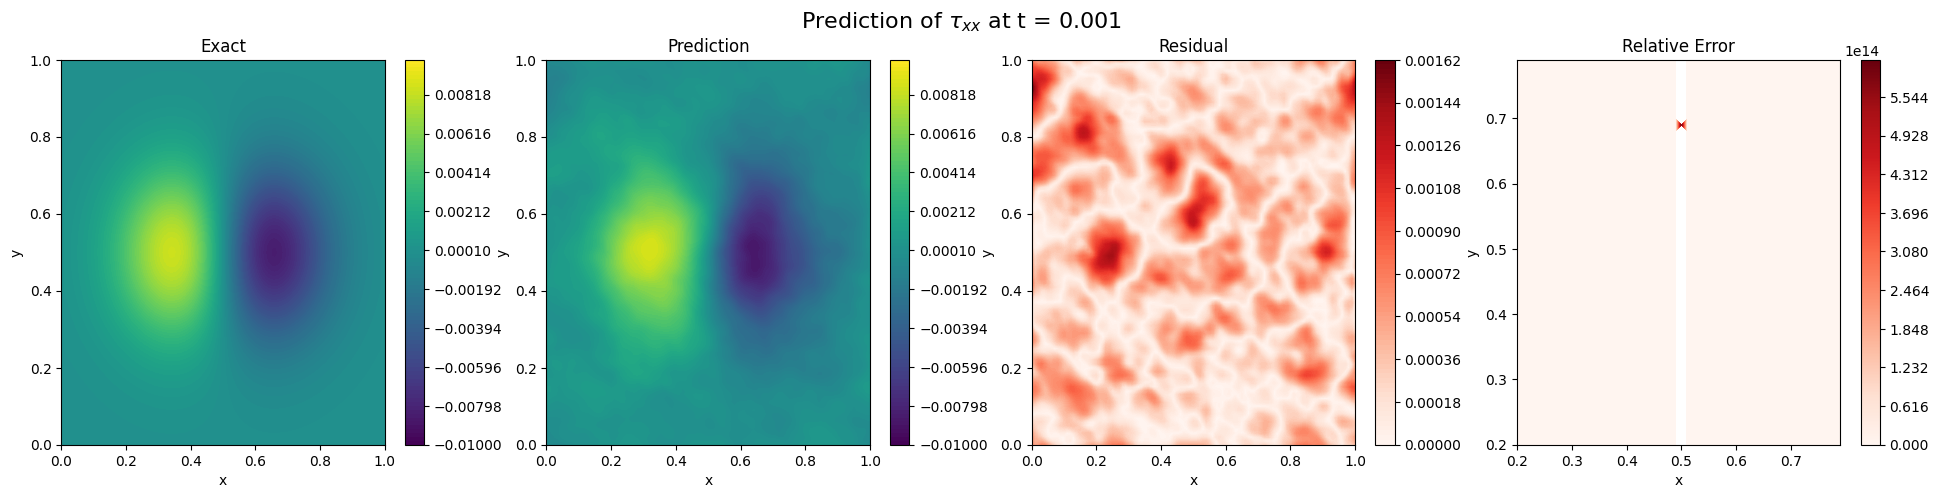

In [ ]:
index = 10
levels = np.linspace(-0.01,0.01,100)
levels_res = 100
fig,ax=plt.subplots(1,4, figsize = (24,5))
cp0 = ax[0].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), tauxx[:,:,index].reshape((101,101)), levels)
cp1 = ax[1].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), tauxx_pred[:,:,index].reshape((101,101)), levels)
cp2 = ax[2].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), np.abs((tauxx[:,:,index].reshape((101,101)) - tauxx_pred[:,:,index].reshape((101,101)))), levels_res, cmap=cm.Reds)
cp3 = ax[3].contourf(xv[20:80,20:80,0].reshape((60,60)), yv[20:80,20:80,0].reshape((60,60)), np.abs((tauxx[20:80,20:80,index] - tauxx_pred[20:80,20:80,index].reshape((60,60)))/tauxx[20:80,20:80, index]), 1000, cmap=cm.Reds)

fig.colorbar(cp3, ax=ax[3])
fig.colorbar(cp2, ax=ax[2])
fig.colorbar(cp1, ax=ax[1])
fig.colorbar(cp0, ax=ax[0])

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[3].set_xlabel('x')
ax[3].set_ylabel('y')

ax[0].set_title('Exact')
ax[1].set_title('Prediction')
ax[2].set_title('Residual')
ax[3].set_title('Relative Error')
fig.suptitle(r'Prediction of $\tau_{xx}$ at t = 0.001', fontsize=16)

<ipython-input-14-d6e8974ddf58>:8: RuntimeWarning: divide by zero encountered in divide
  cp3 = ax[3].contourf(xv[20:80,20:80,0].reshape((60,60)), yv[20:80,20:80,0].reshape((60,60)), np.abs((tauyy[20:80,20:80,index] - tauyy_pred[20:80,20:80,index].reshape((60,60)))/tauyy[20:80,20:80, index]), 1000, cmap=cm.Reds)


Text(0.5, 0.98, 'Prediction of $\\tau_{yy}$ at t = 0.001')

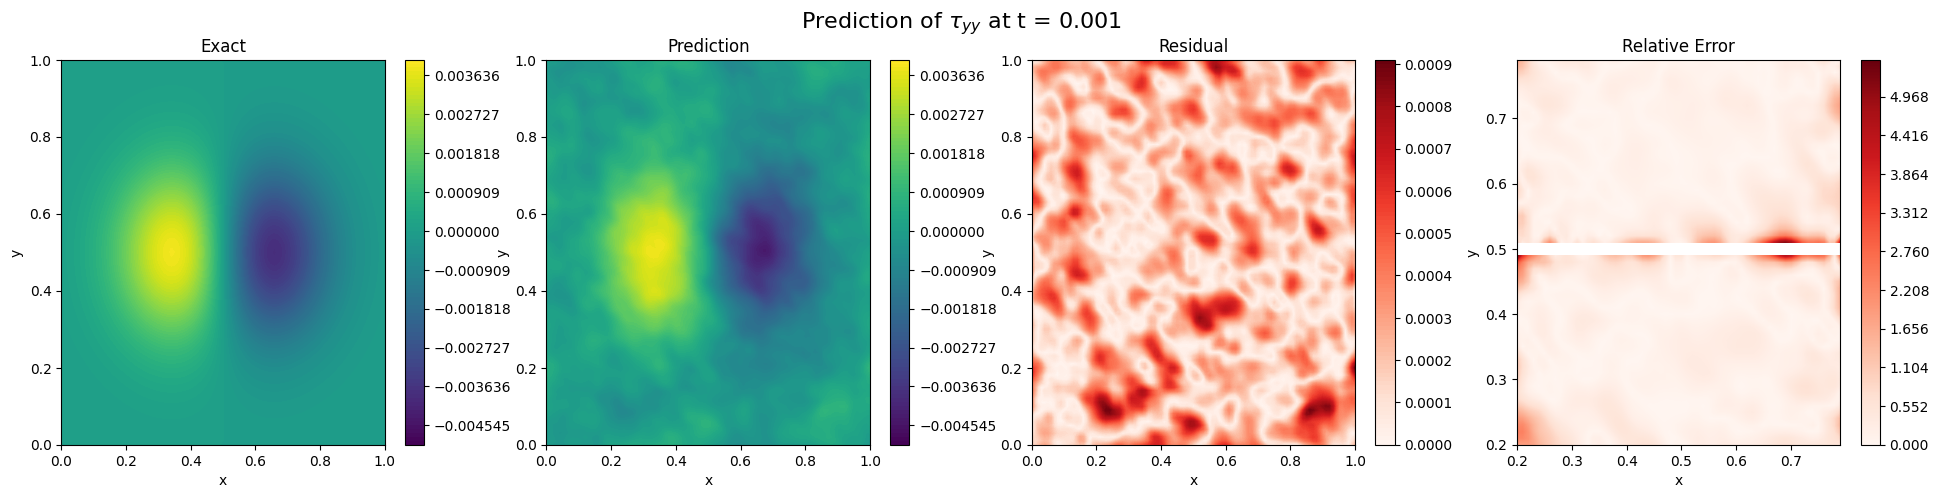

In [ ]:
index = 10
levels = np.linspace(-0.005,0.004,100)
levels_res = 100
fig,ax=plt.subplots(1,4, figsize = (24,5))
cp0 = ax[0].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), tauyy[:,:,index].reshape((101,101)), levels)
cp1 = ax[1].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), tauyy_pred[:,:,index].reshape((101,101)), levels)
cp2 = ax[2].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), np.abs((tauyy[:,:,index].reshape((101,101)) - tauyy_pred[:,:,index].reshape((101,101)))), levels_res, cmap=cm.Reds)
cp3 = ax[3].contourf(xv[20:80,20:80,0].reshape((60,60)), yv[20:80,20:80,0].reshape((60,60)), np.abs((tauyy[20:80,20:80,index] - tauyy_pred[20:80,20:80,index].reshape((60,60)))/tauxy[20:80,20:80, index]), 1000, cmap=cm.Reds)

fig.colorbar(cp3, ax=ax[3])
fig.colorbar(cp2, ax=ax[2])
fig.colorbar(cp1, ax=ax[1])
fig.colorbar(cp0, ax=ax[0])

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[3].set_xlabel('x')
ax[3].set_ylabel('y')

ax[0].set_title('Exact')
ax[1].set_title('Prediction')
ax[2].set_title('Residual')
ax[3].set_title('Relative Error')
fig.suptitle(r'Prediction of $\tau_{yy}$ at t = 0.001', fontsize=16)